 **Task a) Load and Prepare Data
Load CIFAR-20 Data**: Use keras.datasets.cifar100 with "coarse" labels.
Convert to Grayscale: Average RGB values.
Prepare Stratified Validation Set: Use train_test_split from sklearn with stratification on labels.

In [1]:
import numpy as np
import tensorflow.keras.datasets as tfd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load CIFAR-20 dataset
(train_data, test_data) = tfd.cifar100.load_data(label_mode="coarse")
(x_train, y_train), (x_test, y_test) = train_data, test_data

# Convert to grayscale
x_train = np.mean(x_train, axis=3, keepdims=True) / 255.0
x_test = np.mean(x_test, axis=3, keepdims=True) / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 20)
y_test = to_categorical(y_test, 20)

# Create stratified validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train.argmax(axis=1), random_state=42
)


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


**Task b) Design and Train Customized CNN**

1.  Architecture Variations: Experiment with depth (convolutional layers) and width (number of filters).
2.  Loss Function: Use categorical_crossentropy since this is multi-class classification.

3.   Early Stopping: Monitor validation loss to prevent overfitting.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd

# Define CNN architectures
def create_model(depth, filters, dropout_rate=0.5):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 1)))  # Define input shape here
    for _ in range(depth):
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation='softmax'))  # 20 classes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train and evaluate different architectures
results = []
depths = [2, 3, 4]  # Vary depth
filters = [32, 64]  # Vary width

for d in depths:
    for f in filters:
        model = create_model(d, f)
        history = model.fit(
            x_train, y_train, epochs=20, batch_size=64,
            validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )
        results.append({
            'depth': d,
            'filters': f,
            'train_acc': max(history.history['accuracy']),
            'val_acc': max(history.history['val_accuracy'])
        })



# Create DataFrame from results
results_df = pd.DataFrame(results)
print("Architectures Performance:")
print(results_df)

# Save to CSV (optional)
results_df.to_csv("architectures_performance.csv", index=False)



Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1004 - loss: 2.8920 - val_accuracy: 0.2307 - val_loss: 2.5736
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2147 - loss: 2.5822 - val_accuracy: 0.2698 - val_loss: 2.4046
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2503 - loss: 2.4583 - val_accuracy: 0.3169 - val_loss: 2.2926
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2712 - loss: 2.3690 - val_accuracy: 0.3357 - val_loss: 2.2081
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3011 - loss: 2.2742 - val_accuracy: 0.3478 - val_loss: 2.1523
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3170 - loss: 2.2160 - val_accuracy: 0.3610 - val_loss: 2.1121
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3343 - loss: 2.1624 - val_accuracy: 0.3516 - val_loss: 2.1267
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3419 - loss: 2.1182 - val_accuracy: 0.

**Task c) Compare Regularization**
Test L2 regularization and dropout rates.

In [5]:
from tensorflow.keras.regularizers import l2

# Modify model creation for L2
def create_model_with_l2(depth, filters, l2_rate=0.01, dropout_rate=0.5):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 1)))
    for _ in range(depth):
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same',
                         kernel_regularizer=l2(l2_rate)))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation='softmax'))  # 20 classes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Test different regularization
l2_rates = [0.001, 0.01]
dropout_rates = [0.3, 0.5]

reg_results = []
for l2_rate in l2_rates:
    for dropout_rate in dropout_rates:
        model = create_model_with_l2(3, 64, l2_rate, dropout_rate)
        history = model.fit(
            x_train, y_train, epochs=20, batch_size=64,
            validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )
        reg_results.append({
            'l2_rate': l2_rate,
            'dropout_rate': dropout_rate,
            'train_acc': max(history.history['accuracy']),
            'val_acc': max(history.history['val_accuracy'])
        })

# Create DataFrame for regularization results
reg_results_df = pd.DataFrame(reg_results)
print("Regularization Performance:")
print(reg_results_df)

# Save to CSV (optional)
reg_results_df.to_csv("regularization_performance.csv", index=False)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1051 - loss: 2.9834 - val_accuracy: 0.2248 - val_loss: 2.6424
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2211 - loss: 2.6342 - val_accuracy: 0.2648 - val_loss: 2.5123
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2581 - loss: 2.5272 - val_accuracy: 0.2851 - val_loss: 2.4498
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2845 - loss: 2.4662 - val_accuracy: 0.3091 - val_loss: 2.3924
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3012 - loss: 2.4131 - val_accuracy: 0.3354 - val_loss: 2.3307
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3218 - loss: 2.3499 - val_accuracy: 0.3515 - val_loss: 2.3040
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3372 - loss: 2.3077 - val_accuracy: 0.3545 - val_loss: 2.2821
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3488 - loss: 2.2769 - val_accuracy: 0.

**Part d) Final Model Training and Architecture Summary**
Here, I finalize the architecture based on the best results from parts b and c.

Final Model Architecture:
Depth: 3 Conv Layers
Width: 64 Filters
Regularization: L2 (0.001) and Dropout (0.3)
Optimizer: Adam with learning rate 0.001
Epochs: 20 with early stopping
Batch Size: 64

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0953 - loss: 3.0102 - val_accuracy: 0.1906 - val_loss: 2.6942
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2070 - loss: 2.6701 - val_accuracy: 0.2505 - val_loss: 2.5538
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2453 - loss: 2.5695 - val_accuracy: 0.2775 - val_loss: 2.4870
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2722 - loss: 2.4953 - val_accuracy: 0.2946 - val_loss: 2.4286
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2896 - loss: 2.4420 - val_accuracy: 0.3161 - val_loss: 2.3743
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3092 - loss: 2.3820 - val_accuracy: 0.3359 - val_loss: 2.3192
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3224 - loss: 2.3562 - val_accuracy: 0.3471 - val_loss: 2.3132
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3374 - loss: 2.3141 - val_accuracy: 0.

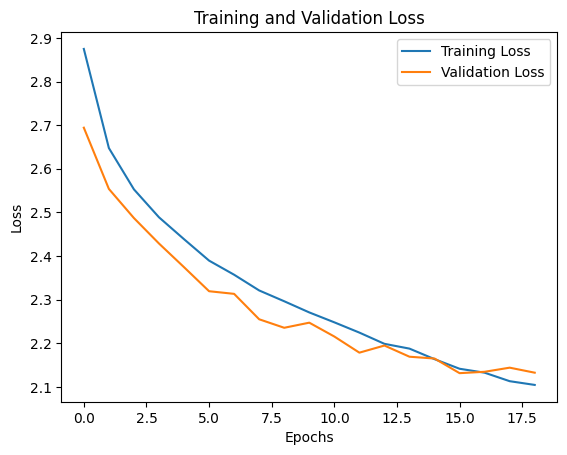

Final Test Accuracy: 40.62%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


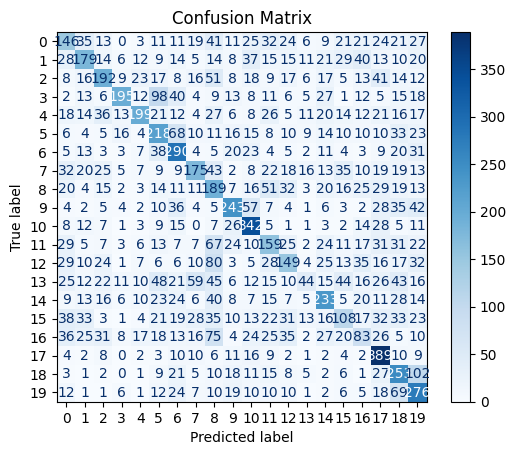

In [7]:
# Final model architecture
final_model = create_model_with_l2(depth=3, filters=64, l2_rate=0.001, dropout_rate=0.3)

# Train on full training set
final_history = final_model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# Save final model
final_model.save("final_cnn_model.keras")

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.2%}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = final_model.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(20))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


**Part e) Evaluation on Perturbed Dataset**

Load Perturbed Test Set: Use provided .pkl file.

Apply Model Modifications:
Batch Normalization
Residual Connections
Data Augmentation
Larger Filters
Deeper Networ

**Compare Results:** I Create a table to showing accuracies on training, test, and perturbed datasets.

In [8]:
# Load perturbed dataset
import pickle

dict = pickle.load(open('/content/cifar20_perturb_test.pkl', 'rb'))
x_perturb, y_perturb = dict['x_perturb'], dict['y_perturb']

# Convert to grayscale
x_perturb = np.mean(x_perturb, axis=3, keepdims=True) / 255.0
y_perturb = to_categorical(y_perturb, 20)

# Evaluate final model on perturbed test set
perturb_loss, perturb_accuracy = final_model.evaluate(x_perturb, y_perturb, verbose=0)
print(f"Final Perturbed Test Accuracy: {perturb_accuracy:.2%}")

# Experiment with modifications
modifications_results = []

# 1. Batch Normalization
def create_model_with_bn(depth, filters):
    model = Sequential()
    for _ in range(depth):
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train and evaluate modified models
for mod_name, model_fn in [("BatchNorm", create_model_with_bn)]:
    modified_model = model_fn(depth=3, filters=64)
    modified_model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=0)
    train_acc = modified_model.evaluate(x_train, y_train, verbose=0)[1]
    test_acc = modified_model.evaluate(x_test, y_test, verbose=0)[1]
    perturb_acc = modified_model.evaluate(x_perturb, y_perturb, verbose=0)[1]
    modifications_results.append({
        "Modification": mod_name,
        "Train Acc": train_acc,
        "Test Acc": test_acc,
        "Perturbed Acc": perturb_acc
    })

# Results Table
modifications_df = pd.DataFrame(modifications_results)
print("Modifications Performance:")
print(modifications_df)


Final Perturbed Test Accuracy: 37.83%
Modifications Performance:
  Modification  Train Acc  Test Acc  Perturbed Acc
0    BatchNorm     0.4994    0.3738         0.3119
